In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_with_error_bars(scenario, partition, affinity, datatype, libraries, base_dir,ttp = None):
    """
    Plots performance data with error bars for given libraries and conditions.
    
    Parameters:
    - scenario: The scenario under which the data was collected (e.g., 'fixed_cores').
    - partition: The partition type (e.g., 'thin').
    - affinity: The affinity condition (e.g., 'close').
    - datatype: The type of data (e.g., 'double').
    - libraries: List of libraries to plot (e.g., ['blis', 'openblas', 'mkl']).
    - base_dir: The base directory where the data files are located.
    """
    plt.figure(figsize=(10, 6))  # Initialize the plot
    x_axis = []

    # Process each library
    for l in libraries:
        filename = f"{l}_{datatype}.csv"
        file_path = os.path.join(base_dir, scenario, partition, affinity, filename)

        # Check if the file exists
        if os.path.exists(file_path):
            with open(file_path, 'r') as f:
                data = f.readlines()
                if(scenario == 'fixed_cores'):
                    x = [int(line.split(',')[0]) for line in data[1:]]  # Matrix sizes, skip header
                    y = [float(line.split(',')[3]) for line in data[1:]]  # GFLOPS, skip header
                    sd = [float(line.split(',')[4]) for line in data[1:]]  # Standard deviation, skip header
                else:
                    x = [int(line.split(',')[0]) for line in data[1:]]
                    y = [float(line.split(',')[1]) for line in data[1:]]
                    y = [y[0]/y_i for y_i in y] # speedup
                    sd = [float(line.split(',')[2]) for line in data[1:]]
                    sd = [np.abs(y[0]/y_i)*np.sqrt((sd[0]/y[0])**2+(sd_i/y_i)**2) for sd_i,y_i in zip(sd,y)] # speedup error
                

                if partition == 'thin':
                    x_axis.extend(x) # Add x values to the x-axis
                else:
                    x_axis = x

                # Plot the data and fill between for error display
                if scenario == 'fixed_cores':
                    plt.plot(x, y, label=f'{l}_{datatype}', marker='o')
                else:
                    plt.plot(x, y, label=f'{l}_{datatype}')
                    
                plt.fill_between(x, [y_i - sd_i for y_i, sd_i in zip(y, sd)],
                                 [y_i + sd_i for y_i, sd_i in zip(y, sd)], alpha=0.2)
        else:
            print(f"File not found: {file_path}")

    
    # Plot the theoretical peak performance
    if ttp is not None:
        plt.axhline(y=ttp, label=f'Theoretical Peak {ttp} GFLOPS', linestyle='--', color='red')
    elif ttp is None:
        y = x
        plt.plot(x,y, label=f'Theoretical Speedup', linestyle='--', color='red')
        


    # Setting plot attributes
    if(scenario == 'fixed_cores'):
        if partition == 'thin':
            plt.ylim([500, 2100])
        elif partition == 'epyc':
            plt.ylim([0, 5500])
        plt.xlabel('Matrix Size')
        plt.ylabel('GFLOPS')
        plt.title(f'{partition.capitalize()}, {affinity.capitalize()}, {datatype.capitalize()}: GFLOPS vs Matrix Size', fontsize='x-large', fontweight='bold', backgroundcolor='mediumaquamarine',color='white')
    else:
        plt.xlabel('Number of Cores')
        plt.ylabel('Speedup (s)')
        plt.title(f'{partition.capitalize()}, {affinity.capitalize()}, {datatype.capitalize()}: Speedup vs Number of Cores', fontsize='x-large', fontweight='bold', backgroundcolor='mediumturquoise',color='white')

    plt.legend(fontsize='small')
    plt.grid(which='major', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
    if partition == 'thin':
        plt.minorticks_on()
        plt.xticks(ticks=sorted(set(x_axis)),rotation=45, fontsize='small')
        
    plt.savefig(os.path.join(base_dir, f'plot/{scenario}/{partition}-{affinity}-{datatype}.png'))


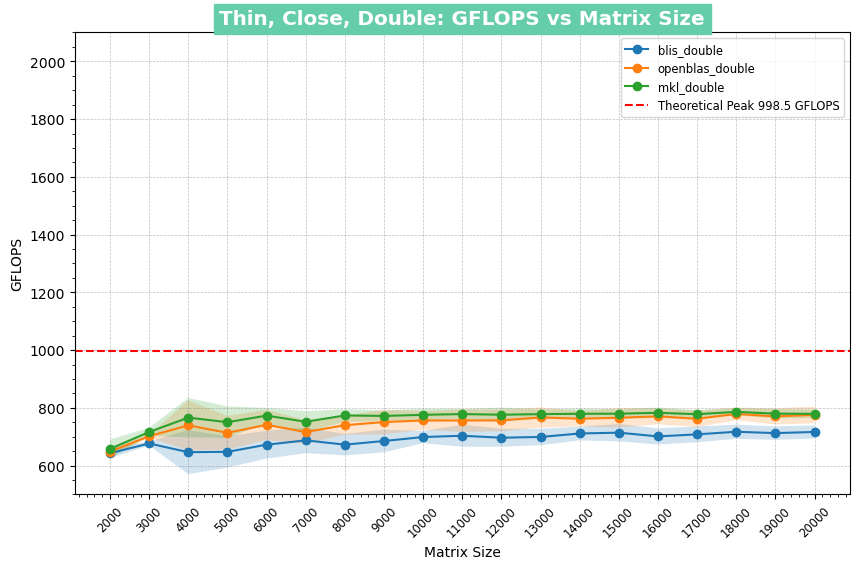

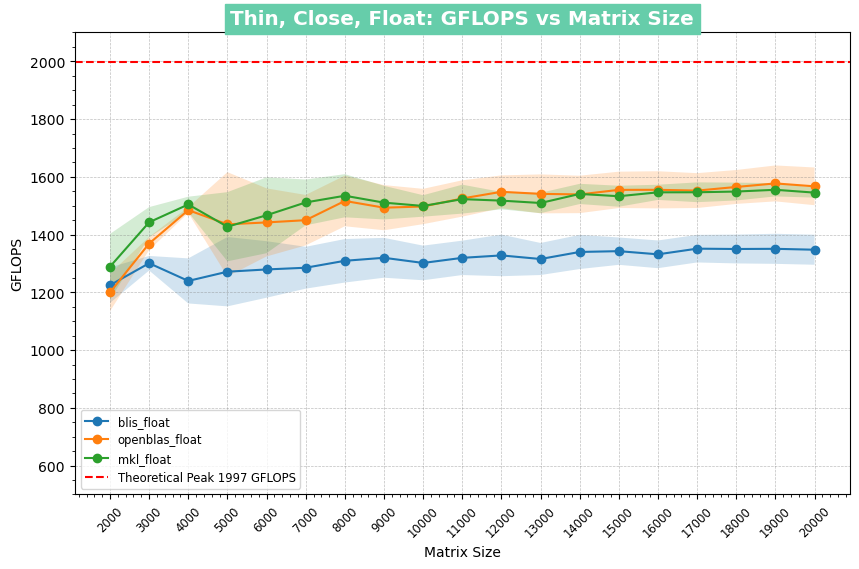

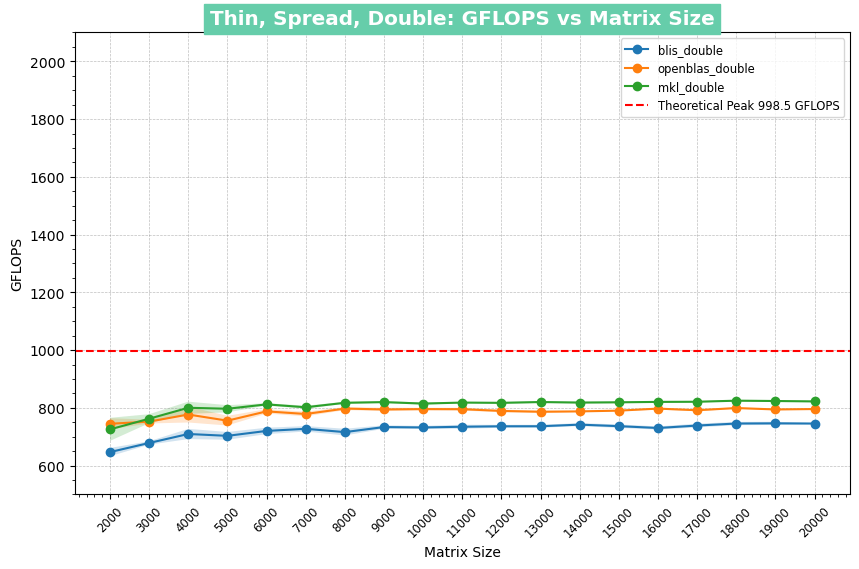

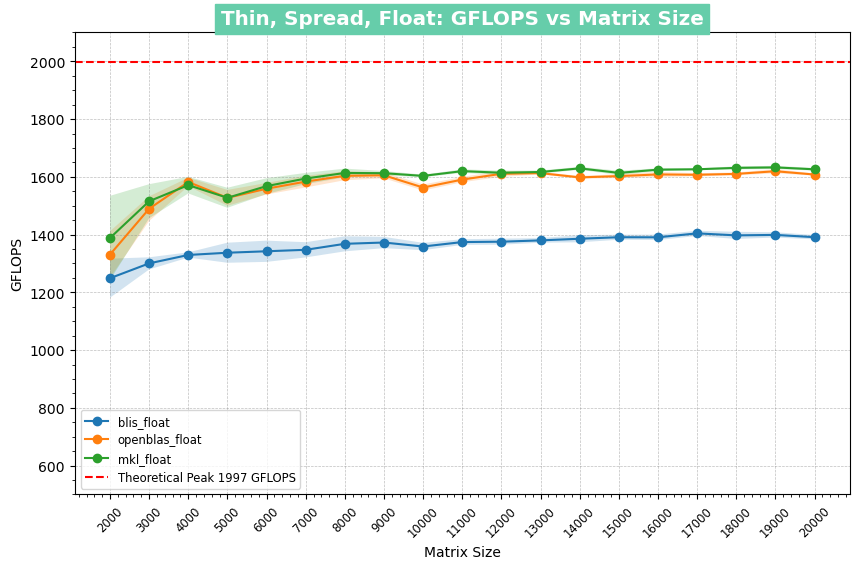

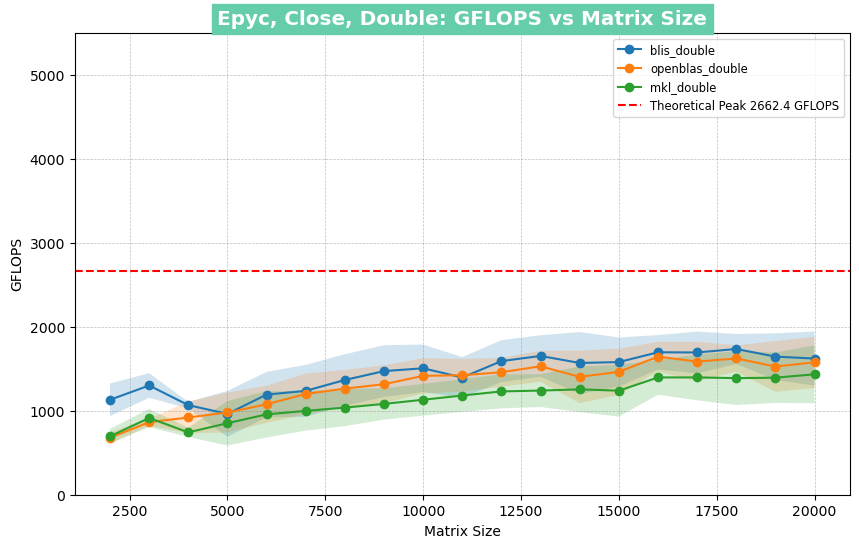

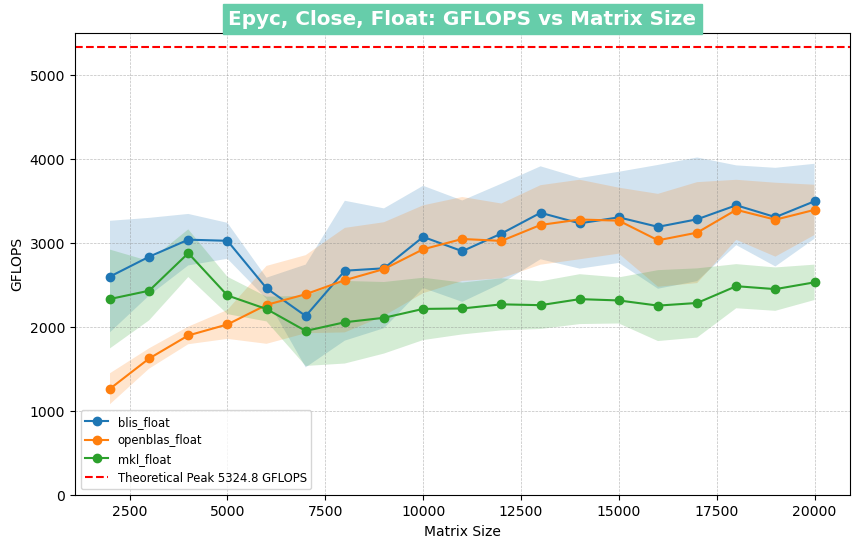

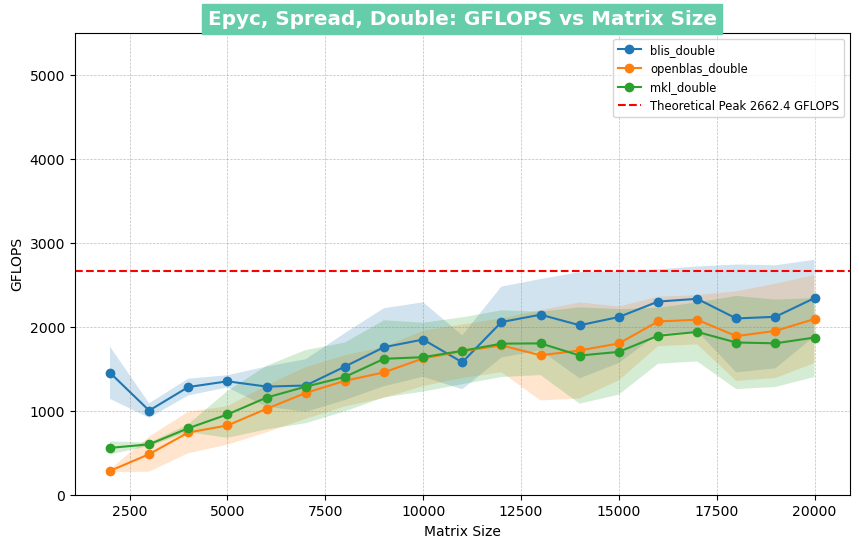

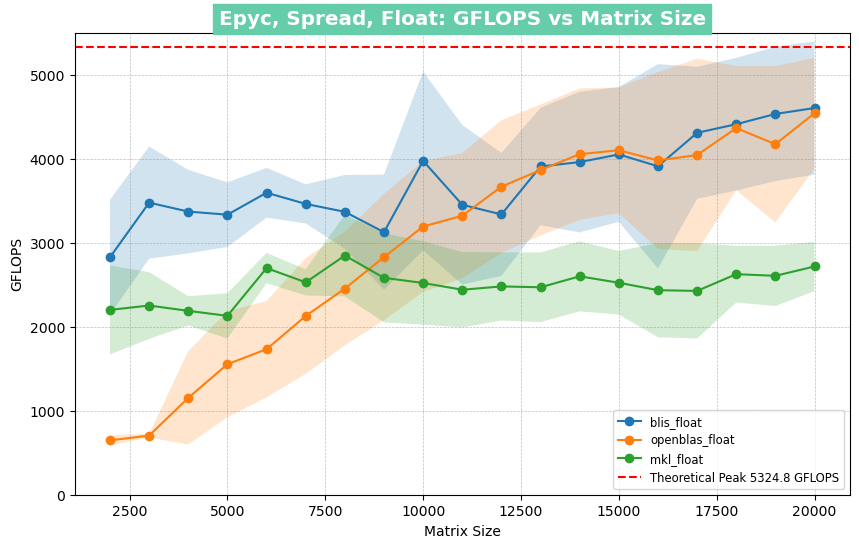

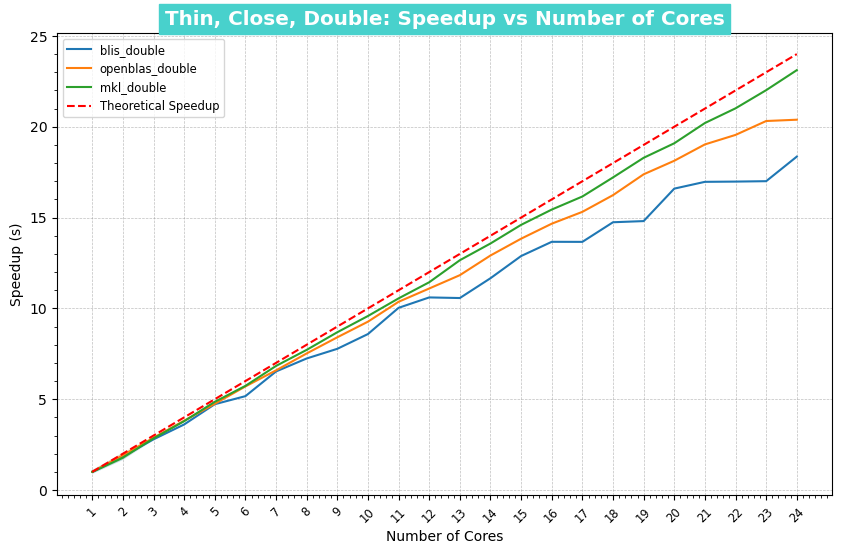

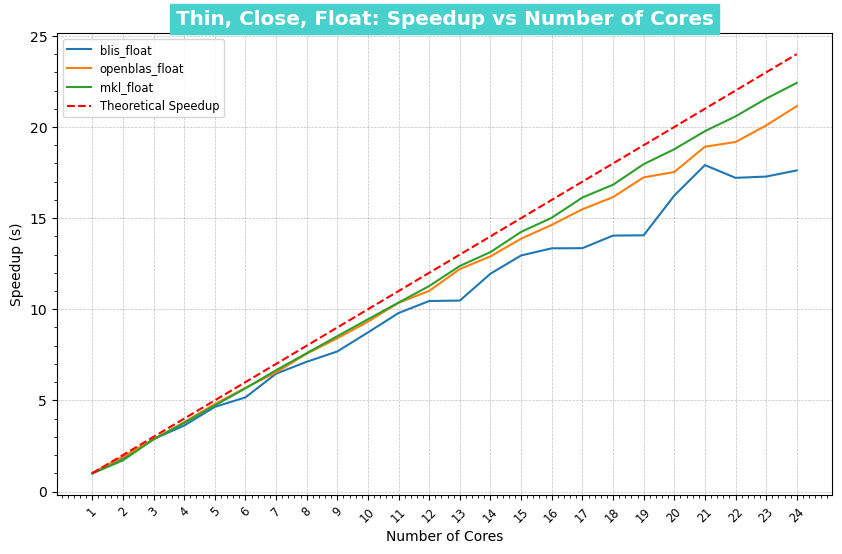

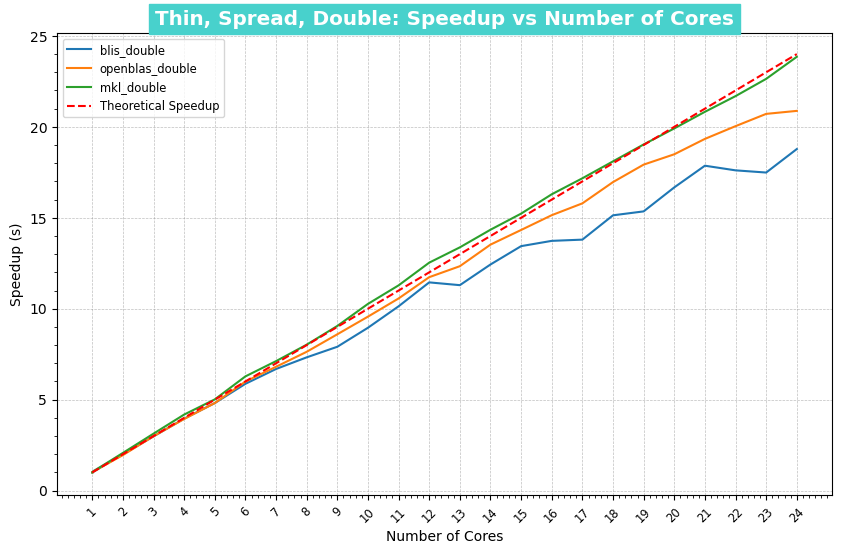

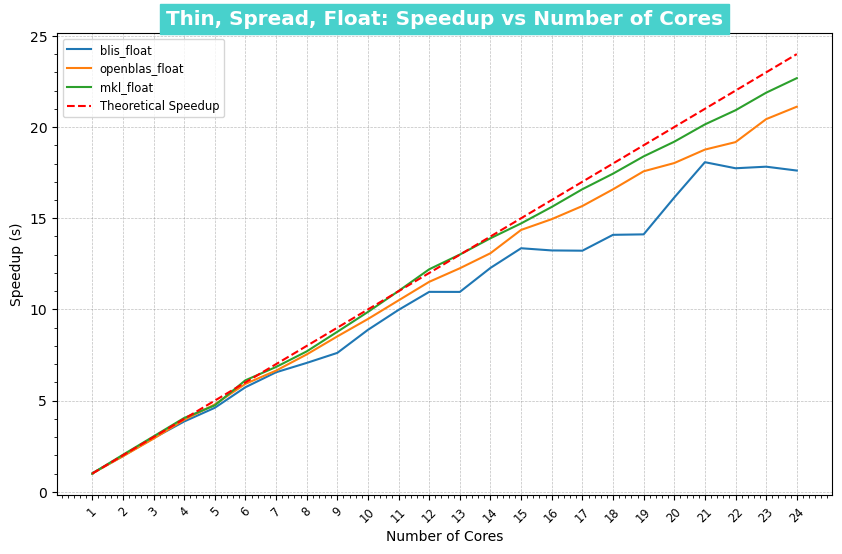

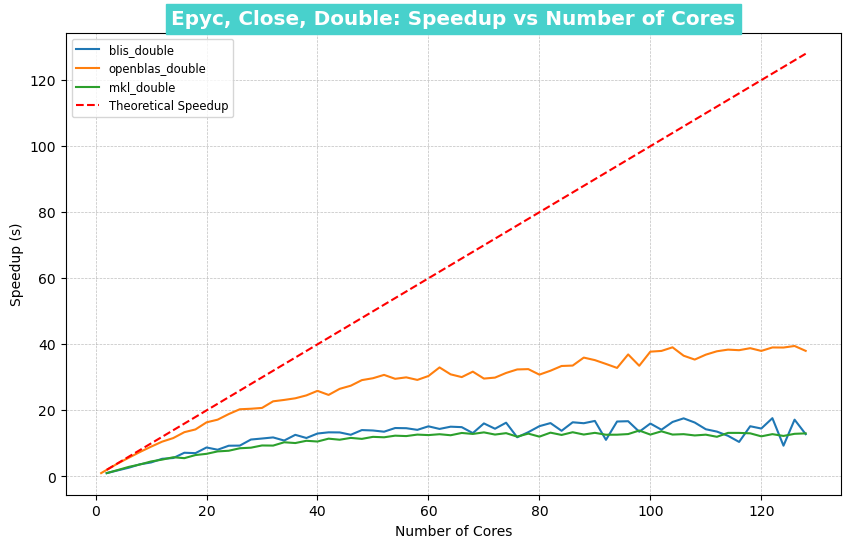

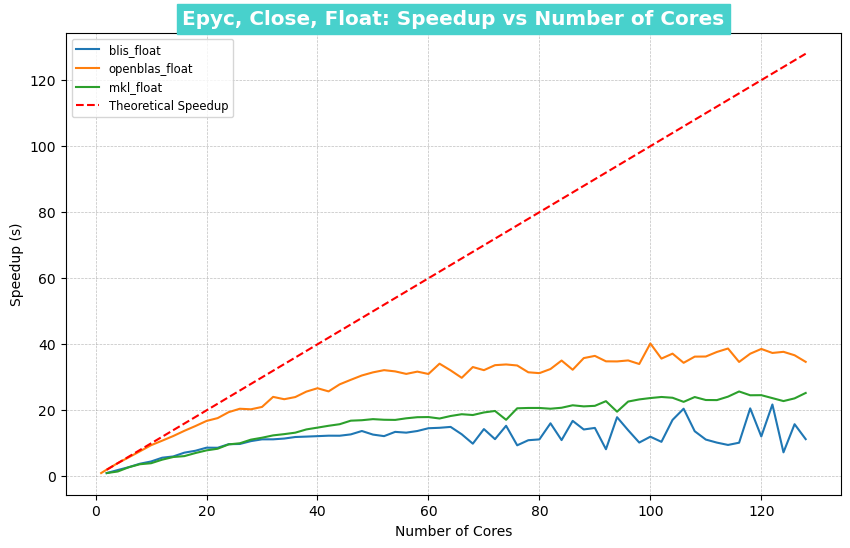

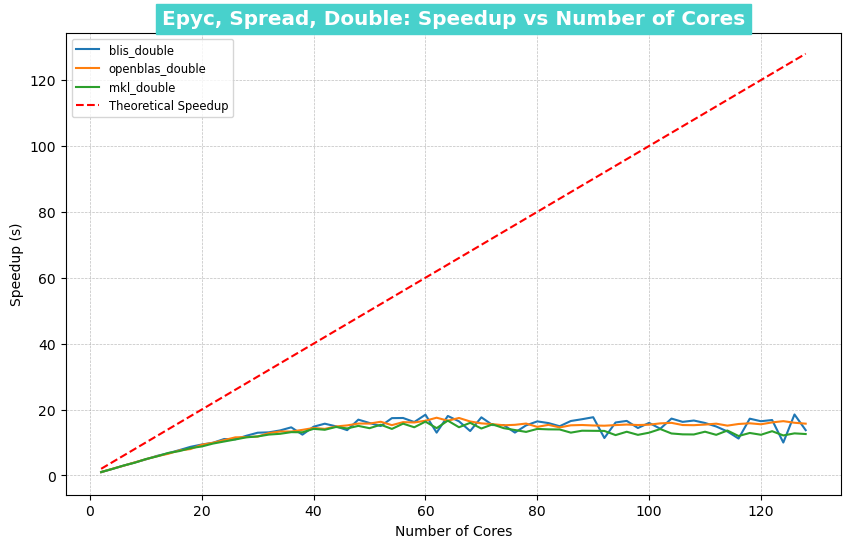

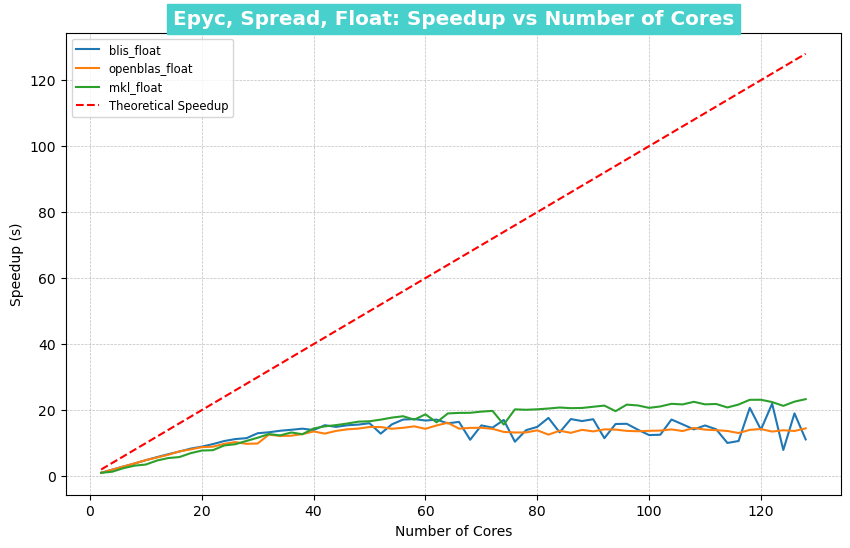

In [20]:
scenario = ['fixed_cores','fixed_size']
partition = ['thin','epyc']
affinity = ['close','spread']
library = ['blis','openblas','mkl']
datatype = ['double','float']

# read the data from the file

for s in scenario:
    for p in partition:
        for a in affinity:
            for d in datatype:

                if s == 'fixed_cores':

                    if d == 'float' and  p=='epyc' and s == 'fixed_cores':
                        ttp = 64 * 2.6 * 32 
                    elif d == 'double' and  p=='epyc' and s == 'fixed_cores':
                        ttp = 64 * 2.6 * 16
                    elif d == 'float' and  p=='thin':
                        ttp = 1997 # from lecture 2 slides 63
                    elif d == 'double' and  p=='thin':
                        ttp = 1997/2
                    else:
                        ttp = None
                
                else:
                    ttp = None

                plot_with_error_bars(s, p, a, d, library, '',ttp)
            
 

